# Laboratorio 1 - Agrometeorología (FS-0918)
# Kevin Facey Torres - B52591

Mediante los procedimientos descritos en este documento se obtienen valores del Índice de Vegetación de Diferencia Normalizada  (NDVI) a partir de los datos recopilados por el satélite geoestacionario GOES-East, cuya información de descarga se encuentra en el sitio: https://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi  

Primeramente es necesario instalar algunos módulos útiles para la descarga y manipulación de los datos satelitales.

In [ ]:
!pip install --upgrade pip
!pip install netcdf4
!pip uninstall -y shapely imgaug
!pip install cartopy
!pip install shapely --no-binary shapely --force
!pip install boto3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 22.0.4
    Uninstalling pip-22.0.4:
      Successfully uninstalled pip-22.0.4
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
Found existing installation: shapely 2.0.1
Uninstalling shapely-2.0.1:
  Successfully uninstalled shapely-2.0.1
Found existing installation: imgaug 0.4.0
Uninstalling imgaug-0.4.0:
  Successfully uninstalled imgaug-0.4.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 71.6 MB/s eta 0:00:00
  Installing build depe

In [ ]:
!wget -c https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py

--2023-03-30 20:18:55--  https://www.dropbox.com/s/i8j1g9xg1g7o56l/utilities.py
Resolving www.dropbox.com (www.dropbox.com)... 162.125.80.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.80.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/i8j1g9xg1g7o56l/utilities.py [following]
--2023-03-30 20:18:56--  https://www.dropbox.com/s/raw/i8j1g9xg1g7o56l/utilities.py
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucee7ab07b5521825a39fa1ef609.dl.dropboxusercontent.com/cd/0/inline/B5MNHfZbWWTY9VtgiEMrRQRwOeyd7iAIQ6ZW3XhJTi4KhoSLKFraoCw-lc4tYklZRa8VEi-uhnEV6hk95fRsiLdoSX3ekvWrwxN9hMbxD5hxCqW3le_MOPCdoWrElkbAQsniS8p2X7v_B_nnSgFA87ptiU72ym3RGQUudYCyiJglIQ/file# [following]
--2023-03-30 20:18:56--  https://ucee7ab07b5521825a39fa1ef609.dl.dropboxusercontent.com/cd/0/inline/B5MNHfZbWWTY9VtgiEMrRQRwOeyd7iAIQ6ZW3XhJTi4KhoSLKFraoCw-lc4tYklZRa8VEi-uhnEV6

# Parte I: Graficación de valores NDVI para Belice

Por medio del siguiente código se importan los módulos necsarios, se descargan los datos del satélite y se grafica una región específica, que en este caso corresponde a Belice.

File /content/Samples/OR_ABI-L2-CMIPF-M6C02_G16_s20200831800217_e20200831809525_c20200831810003.nc exists
File /content/Samples/OR_ABI-L2-CMIPF-M6C03_G16_s20200831800217_e20200831809525_c20200831810009.nc exists
(287, 144) (287, 144)


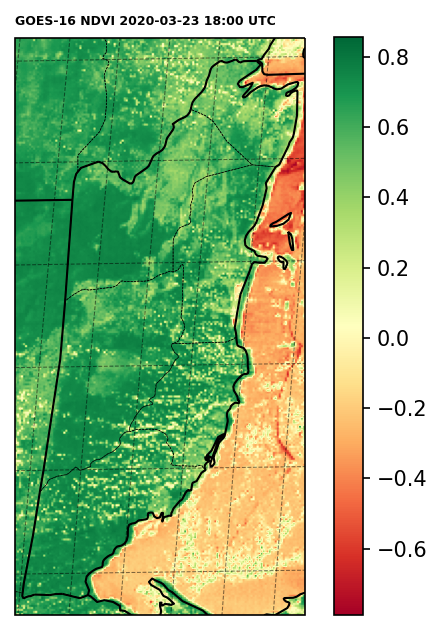

In [ ]:
# Training: Python and GOES-R Imagery: Script 13 - Cropping the Full Disk and Creating an RGB
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset              # Read / Write NetCDF4 files
import matplotlib.pyplot as plt          # Plotting library
from datetime import datetime            # Basic Dates and time types
import cartopy, cartopy.crs as ccrs      # Plot maps
import numpy as np                       # Scientific computing with Python
import os                                # Miscellaneous operating system interfaces
from utilities import download_CMI       # Our own utilities
from utilities import geo2grid, latlon2xy, convertExtent2GOESProjection      # Our own utilities
#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# Datetime to process
yyyymmddhhmn = '202003231800'

# Desired extent
extent = [-89.28, 15.789, -88.10, 18.58] # Min lon, Max lon, Min lat, Max lat

#-----------------------------------------------------------------------------------------------------------
# Download the necessary bands from AWS
file_ch02 = download_CMI(yyyymmddhhmn, 2, input)
file_ch03 = download_CMI(yyyymmddhhmn, 3, input)

#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R images
file_ch02 = Dataset(f'{input}/{file_ch02}.nc')
file_ch03 = Dataset(f'{input}/{file_ch03}.nc')
#-----------------------------------------------------------------------------------------------------------                   
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch02)
ury, urx = geo2grid(extent[3], extent[2], file_ch02)

# Get the pixel values
data_ch02 = file_ch02.variables['CMI'][ury:lly, llx:urx][::2 ,::2] 
#-----------------------------------------------------------------------------------------------------------
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch03)
ury, urx = geo2grid(extent[3], extent[2], file_ch03)

# Get the pixel values
data_ch03 = file_ch03.variables['CMI'][ury:lly, llx:urx][::1 ,::1] 
#-----------------------------------------------------------------------------------------------------------
print(np.shape(data_ch03),np.shape(data_ch02))
# Make the arrays equal size

cordX = np.shape(data_ch02)[0], np.shape(data_ch03)[0]
cordY = np.shape(data_ch02)[1], np.shape(data_ch03)[1]

minvalX = np.array(cordX).min()
minvalY = np.array(cordY).min()

data_ch02 = data_ch02[0:minvalX, 0:minvalY]
data_ch03 = data_ch03[0:minvalX, 0:minvalY]
#-----------------------------------------------------------------------------------------------------------
# Compute data-extent in GOES projection-coordinates
img_extent = convertExtent2GOESProjection(extent)              
#-----------------------------------------------------------------------------------------------------------

NDVI = (data_ch03 - data_ch02)/(data_ch03 + data_ch02)

#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(5,5), dpi=150)

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Plot the image
colormap = "RdYlGn"
plt.imshow(NDVI, origin='upper', extent=img_extent, cmap=colormap)


# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=1.0)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=1.0)
ax.add_feature(cartopy.feature.STATES, edgecolor='black',linestyle='--', linewidth=0.3)
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

# Extract date
date = (datetime.strptime(file_ch02.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 NDVI ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=6, loc='left')
#plt.title('Reg.: ' + str(extent) , fontsize=6, loc='right')

#Add colorbar
plt.colorbar()
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/NDVI.png', bbox_inches='tight', pad_inches=0, dpi=300)
            
# Show the image
plt.show()

#Graficación de NDVI para Costa Rica

(379, 440) (379, 440)


/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:228: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:280: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/usr/local/lib/python3.7/dist-packages/cartopy/crs.py:347: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


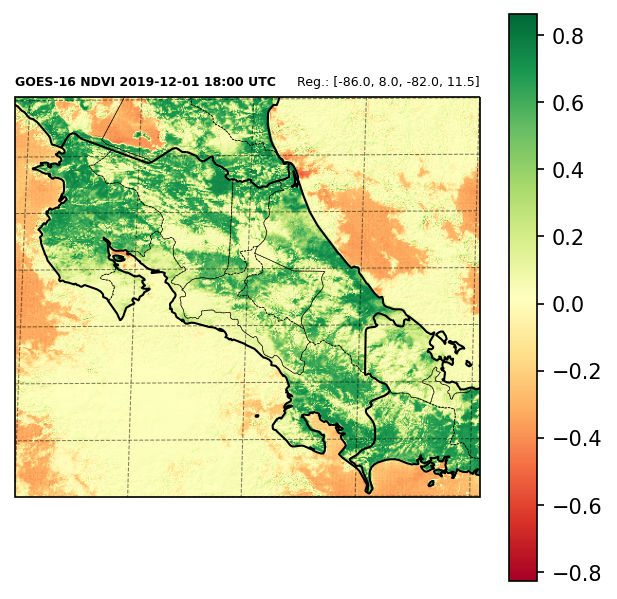

In [ ]:
# Training: Python and GOES-R Imagery: Script 13 - Cropping the Full Disk and Creating an RGB
#-----------------------------------------------------------------------------------------------------------
# Required modules
from netCDF4 import Dataset              # Read / Write NetCDF4 files
import matplotlib.pyplot as plt          # Plotting library
from datetime import datetime            # Basic Dates and time types
import cartopy, cartopy.crs as ccrs      # Plot maps
import numpy as np                       # Scientific computing with Python
import os                                # Miscellaneous operating system interfaces
from utilities import download_CMI       # Our own utilities
from utilities import geo2grid, latlon2xy, convertExtent2GOESProjection      # Our own utilities
#-----------------------------------------------------------------------------------------------------------
# Input and output directories
input = "/content/Samples"; os.makedirs(input, exist_ok=True)
output = "/content/Output"; os.makedirs(output, exist_ok=True)

# Datetime to process
yyyymmddhhmn = '201912011800'

# Desired extent
#extent = [-89.28, 15.789, -88.10, 18.58] # Min lon, Max lon, Min lat, Max lat

extent = [-86.00, 8.00,-82.00, 11.50] # Min lon, Max lon, Min lat, Max lat

#-----------------------------------------------------------------------------------------------------------
# Download the necessary bands from AWS
file_ch02 = download_CMI(yyyymmddhhmn, 2, input)
file_ch03 = download_CMI(yyyymmddhhmn, 3, input)

#-----------------------------------------------------------------------------------------------------------
# Open the GOES-R images
file_ch02 = Dataset(f'{input}/{file_ch02}.nc')
file_ch03 = Dataset(f'{input}/{file_ch03}.nc')
#-----------------------------------------------------------------------------------------------------------                   
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch02)
ury, urx = geo2grid(extent[3], extent[2], file_ch02)

# Get the pixel values
data_ch02 = file_ch02.variables['CMI'][ury:lly, llx:urx][::2 ,::2] 
#-----------------------------------------------------------------------------------------------------------
# Convert lat/lon to grid-coordinates
lly, llx = geo2grid(extent[1], extent[0], file_ch03)
ury, urx = geo2grid(extent[3], extent[2], file_ch03)

# Get the pixel values
data_ch03 = file_ch03.variables['CMI'][ury:lly, llx:urx][::1 ,::1] 
#-----------------------------------------------------------------------------------------------------------
print(np.shape(data_ch03),np.shape(data_ch02))
# Make the arrays equal size

cordX = np.shape(data_ch02)[0], np.shape(data_ch03)[0]
cordY = np.shape(data_ch02)[1], np.shape(data_ch03)[1]

minvalX = np.array(cordX).min()
minvalY = np.array(cordY).min()

data_ch02 = data_ch02[0:minvalX, 0:minvalY]
data_ch03 = data_ch03[0:minvalX, 0:minvalY]
#-----------------------------------------------------------------------------------------------------------
# Compute data-extent in GOES projection-coordinates
img_extent = convertExtent2GOESProjection(extent)              
#-----------------------------------------------------------------------------------------------------------

NDVI = (data_ch03 - data_ch02)/(data_ch03 + data_ch02)

#-----------------------------------------------------------------------------------------------------------
# Choose the plot size (width x height, in inches)
plt.figure(figsize=(5,5), dpi=150)

# Use the Geostationary projection in cartopy
ax = plt.axes(projection=ccrs.Geostationary(central_longitude=-75.0, satellite_height=35786023.0))

# Plot the image
colormap = "RdYlGn"
plt.imshow(NDVI, origin='upper', extent=img_extent, cmap=colormap)


# Add coastlines, borders and gridlines
ax.coastlines(resolution='10m', color='black', linewidth=1.0)
ax.add_feature(cartopy.feature.BORDERS, edgecolor='black', linewidth=1.0)
ax.add_feature(cartopy.feature.STATES, edgecolor='black',linestyle='--', linewidth=0.3)
ax.gridlines(color='black', alpha=0.5, linestyle='--', linewidth=0.5)

# Extract date
date = (datetime.strptime(file_ch02.time_coverage_start, '%Y-%m-%dT%H:%M:%S.%fZ'))

# Add a title
plt.title('GOES-16 NDVI ' + date.strftime('%Y-%m-%d %H:%M') + ' UTC', fontweight='bold', fontsize=6, loc='left')
plt.title('Reg.: ' + str(extent) , fontsize=6, loc='right')

#Add colorbar
plt.colorbar()
#-----------------------------------------------------------------------------------------------------------
# Save the image
plt.savefig(f'{output}/NDVI.png', bbox_inches='tight', pad_inches=0, dpi=300)
            
# Show the image
plt.show()

# Parte II: Obtener valores de NDVI para abril del 2020

El siguiente código, importa librerías útiles, descarga, manipula realiza los cálculos de NDVI en un punto específico.Se crea una función que obtenga los valores de NDVI en el punto específico y los almacene en una lista.

In [ ]:
from netCDF4 import Dataset              # Funciones para archivos tipo NetCDF4
import matplotlib.pyplot as plt          # Funciones de graficación
from datetime import datetime            # Funciones para manipulación y uso de tiempo
import cartopy, cartopy.crs as ccrs      # Graficación de mapas
import numpy as np                       # Funciones para arreglos numéricos
import os                                # Interacción con el sistema operativo
from utilities import download_CMI       # Funciones del archivo utilities.py
from utilities import geo2grid, latlon2xy, convertExtent2GOESProjection      # Funciones del archivo utilities.py
#-----------------------------------------------------------------------------------------------------------


data = []
def my_function(fechas):
  input = "/content/Samples"; os.makedirs(input, exist_ok=True)
  # Fecha y hora de interés
  yyyymmddhhmn = fechas

  # Extensión de interés (Debe contener las coordenadas que se desean extraer)
  extent = [-86.0, 7.789, -82.38, 11.46] # Min lon, Min lat, Max lon, Max lat  

#-----------------------------------------------------------------------------------------------------------
# Descarga de los archivos desde AWS
  file_ch02 = download_CMI(yyyymmddhhmn, 2, input)
  file_ch03 = download_CMI(yyyymmddhhmn, 3, input)

#-----------------------------------------------------------------------------------------------------------
# Lectura de metadatos de los archivos
  file_ch02 = Dataset(f'{input}/{file_ch02}.nc')
  file_ch03 = Dataset(f'{input}/{file_ch03}.nc')
#-----------------------------------------------------------------------------------------------------------                   
# Conversión de coordenadas a grillas
  lly, llx = geo2grid(extent[1], extent[0], file_ch02)
  ury, urx = geo2grid(extent[3], extent[2], file_ch02)

# Lectura de datos de canal 2
  data_ch02 = file_ch02.variables['CMI'][ury:lly, llx:urx][::2 ,::2] 
#-----------------------------------------------------------------------------------------------------------
# Conversión de coordenadas a grillas
  lly, llx = geo2grid(extent[1], extent[0], file_ch03)
  ury, urx = geo2grid(extent[3], extent[2], file_ch03)

# Lectura de datos de canal 3
  data_ch03 = file_ch03.variables['CMI'][ury:lly, llx:urx][::1 ,::1] 

# Cálculo del NDVI para la región de interés
  NDVI = (data_ch03 - data_ch02)/(data_ch03 + data_ch02)

# Definición del lugar para extracción del valor de NDVI
  AI_LAT = 10.900864   #10.900864, -85.001167 (Upala)
  AI_LON = -85.001167

  LOCATION = geo2grid(AI_LAT, AI_LON, file_ch03)
  Mcoordinates = LOCATION[0]-ury, LOCATION[1]-llx

#Recopilación de todos los valores de NDVI calculados
  data.append(NDVI[Mcoordinates])
   

**Creación de la secuencia de fechas**

Este código crea los pasos temporales y posteriormente se recorre cada uno de ellos y se asigna a la función. Por lo tanto, este código calcula todos los valores de NDVI diurnos del mes; sin embargo, las computadoras no tienen la capacidad de procesar tanta información y se agota rápidamente el espacio en el disco duro interno.

In [ ]:
import pandas as pd
#yyyymmddhhmn
dia=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']
dia = np.repeat(dia,60)
hora = ['12','13','14','15','16','17','18','19','20','21','22','23']
hora = [hora]*30
hora = np.repeat(hora,5)
minuto = ['10','20','30','40','50']*360
año = ['2020']*1800
mes = ['04']*1800

fechas = [año,mes,dia,hora,minuto]
fechas = pd.DataFrame(fechas)
fechas = fechas.T

fecha = (fechas[0]+""+fechas[1]+""+fechas[2]+""+fechas[3]+""+fechas[4])
fecha

for i in fecha:
  my_function(i)
  



Por la razón explicada anteriormente se decidió calcular los valores diarios de NDVI mediante el siguiente código.

In [ ]:
import pandas as pd
dia = ['25']*60
hora = ['12','13','14','15','16','17','18','19','20','21','22','23']
hora = np.repeat(hora,5)
minuto = ['00','10','20','30','40','50']*12
año = ['2020']*60
mes = ['04']*60

fechas = [año,mes,dia,hora,minuto]
fechas = pd.DataFrame(fechas)
fechas = fechas.T

fecha = (fechas[0]+""+fechas[1]+""+fechas[2]+""+fechas[3]+""+fechas[4])
fecha

for i in fecha:
  my_function(i)
   


Así, se realizaron los cálculos para cada uno de los días, copiando y almacenando la información en listas independientes durante cada corrida para su posterior graficación.

In [ ]:
print(data)
len(data)

[-0.1977401, 0.32357726, 0.15811521, -0.05806451, 0.3951012, 0.3101232, -0.33748057, 0.19903746, 0.37992832, 0.2753138, 0.17515099, 0.36157027, 0.2893333, 0.1721878, 0.23050657, -0.08766485, -0.063197, 0.023148168, 0.19982626, 0.017551191, 0.084605865, 0.30095324, -0.15621436, 0.17714284, -0.02236423, -0.0136907855, 0.2418418, 0.5758294, -0.1507092, -0.013970985, 0.11926977, 0.20785104, 0.7005738, 0.05235002, -0.04255908, 0.3377211, 0.43311036, 0.45636365, 0.43424785, -0.013783908, 0.60587, 0.18525021, 0.6431718, 0.35225052, 0.4230331, 0.5228572, 0.4888559, 0.56576866, 0.5761821, 0.48375452, 0.54606736, 0.47783253, 0.463807, 0.47003153, 0.4142857, 0.35135138, 0.32051283, 0.26000002, 0.24444447, 0.33333334]


60

In [ ]:
data_01 = [0.0744681, 0.3081081, 0.50326794, 0.2814159, 0.19674039, 0.46104726, 0.56315005, 0.33502534, 0.4070221, 0.43286386, 0.5491975, 0.13036303, 0.20978418, 0.17279558, 0.2510331, -0.048630953, 0.5019355, 0.23370785, 0.52, -0.018633517, 0.49484533, 0.5429309, 0.18728267, 0.11509949, 0.59752667, 0.4767184, 0.10909841, 0.6810564, 0.43034822, 0.33152357, 0.59039354, 0.27300927, 0.20367412, -0.068902664, 0.64940244, 0.41115886, 0.67027026, 0.18664733, 0.50888526, 0.3964413, 0.6330645, 0.37326306, 0.4879227, 0.5542522, 0.607064, 0.69002694, 0.7346394, -0.3563218, 0.38086954, 0.391635, 0.651282, 0.59908885, 0.5048231, 0.56231004, 0.5177305, 0.45812806, 0.4532374, 0.23684207, 0.2857143, 0.26315784]
data_05 = [0.219802, 0.12351947, 0.18181819, 0.2255814, 0.48275864, 0.27764705, 0.38725492, 0.52456844, 0.07075127, 0.26556775, 0.06101104, 0.43045682, 0.3263598, 0.22779159, 0.2347526, 0.53791046, 0.48628426, 0.15812723, 0.49165124, 0.059496578, 0.04368642, 0.24789709, 0.22798114, 0.6149533, 0.49223414, 0.60233164, 0.570607, 0.56981134, 0.6286982, 0.3515625, 0.18414733, 0.6149964, 0.18361582, 0.6219055, 0.7090909, 0.44181976, 0.63709676, 0.6285452, 0.5571776, 0.059415, 0.15774237, 0.59579265, 0.6612903, 0.6517413, 0.65194803, 0.56620437, 0.6440678, 0.62051284, 0.5955473, 0.5551601, 0.60997725, 0.544186, 0.60104984, -0.2146739, 0.44654086, 0.39506167, 0.23595507, 0.08860761, 0.14285713, 0.0]
data_10 = [0.2129964, 0.0034924252, 0.00869566, 0.24725273, 0.09059828, 0.12740605, 0.13478263, 0.19999999, 0.30204776, 0.12942272, 0.09624946, 0.6113034, -0.03001718, 0.25018844, 0.16230771, -0.122134194, 0.25562605, -0.011960138, 0.25148043, 0.50764525, 0.2739444, 0.19762985, 0.2707775, -0.1592072, 0.15629858, 0.0042522936, 0.48619717, 0.72743523, 0.38858193, 0.38583636, 0.55917346, 0.55145925, 0.5557047, 0.35875487, 0.45647842, 0.42841348, 0.070726, 0.23969632, 0.3991098, 0.23157284, 0.28813562, 0.49512675, 0.5028463, 0.6213018, 0.6037992, 0.36363637, 0.5243394, 0.58249164, 0.49079758, 0.6054158, 0.5650224, 0.5662651, 0.5036497, 0.37777776, 0.42337662, 0.29120877, 0.40566036, 0.3157895, 0.27118647, 0.37254903]
data_15 = [0.08391606, 0.12195122, 0.24644032, 0.0679852, 0.3126935, -0.016270371, 0.14264487, 0.15478483, 0.1602709, 0.31535006, 0.09735397, 0.17488475, 0.16569202, 0.06613407, 0.10840708, -0.08055471, 0.05552558, 0.0465428, 0.04428511, 0.062245063, 0.018158237, 0.05228646, 0.075803705, 0.10131195, 0.023489922, 0.0014792981, 0.060685094, 0.14159113, 0.05114053, 0.0380152, 0.08299261, 0.012472146, 0.063886255, 0.07671231, 0.05219308, 0.08192342, 0.09024567, -0.024300242, 0.11656772, 0.18600531, 0.4054054, 0.18001804, 0.16956523, 0.32971016, 0.16403638, 0.08287842, 0.23766814, 0.22949588, 0.28925622, 0.16235782, 0.24923076, 0.34113714, 0.16045845, 0.04428907, 0.14056224, -0.055555597, -0.03067484, 0.18181816, 0.19999997, 0.41176468]
data_25 = [-0.1977401, 0.32357726, 0.15811521, -0.05806451, 0.3951012, 0.3101232, -0.33748057, 0.19903746, 0.37992832, 0.2753138, 0.17515099, 0.36157027, 0.2893333, 0.1721878, 0.23050657, -0.08766485, -0.063197, 0.023148168, 0.19982626, 0.017551191, 0.084605865, 0.30095324, -0.15621436, 0.17714284, -0.02236423, -0.0136907855, 0.2418418, 0.5758294, -0.1507092, -0.013970985, 0.11926977, 0.20785104, 0.7005738, 0.05235002, -0.04255908, 0.3377211, 0.43311036, 0.45636365, 0.43424785, -0.013783908, 0.60587, 0.18525021, 0.6431718, 0.35225052, 0.4230331, 0.5228572, 0.4888559, 0.56576866, 0.5761821, 0.48375452, 0.54606736, 0.47783253, 0.463807, 0.47003153, 0.4142857, 0.35135138, 0.32051283, 0.26000002, 0.24444447, 0.33333334]

Posteriormente se procedió a graficar los valores de NDVI obtenidos durante cinco días diferentes en un punto específico.

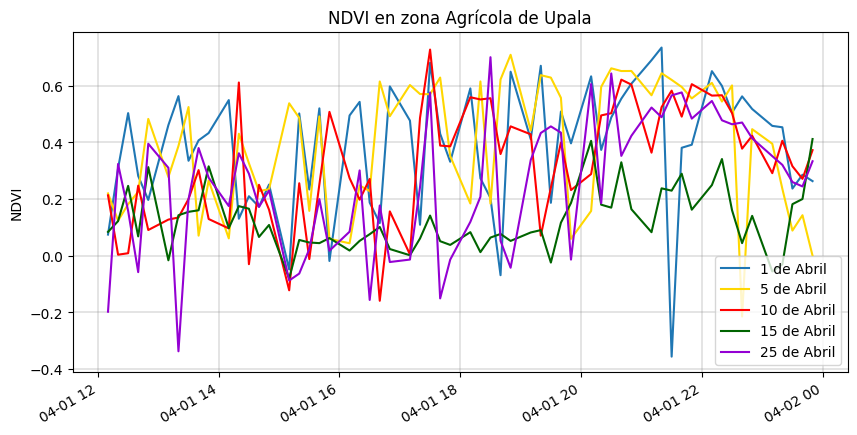

In [ ]:

datetimes = (fechas[0]+"-"+fechas[1]+"-"+fechas[3]+"-"+fechas[4])

datetimes = pd.to_datetime(datetimes,format="%Y-%m-%H-%M")
datetimes

fig = plt.figure(figsize=(10,5),dpi=100)
plt.plot(datetimes,data_01,label = '1 de Abril')
plt.plot(datetimes,data_05,label = '5 de Abril',color = 'gold')
plt.plot(datetimes,data_10,label = '10 de Abril',color = 'red')
plt.plot(datetimes,data_15,label = '15 de Abril',color = 'darkgreen' )
plt.plot(datetimes,data_25,label = '25 de Abril', color = 'darkviolet')
plt.title("NDVI en zona Agrícola de Upala")
plt.ylabel('NDVI')
plt.legend(loc = "best")
plt.grid(True, linewidth=0.3, color = 'gray')
fig.autofmt_xdate()

# Parte III: Valores de NDVI para la misma hora en dos series de tiempo

En este apartado se calculan los valores de NDVI para la misma hora durante todos los días abarcando periodos entre noviembre y abril tanto del 2019-2020 como 2020-2021.

Para esto se recurrió a un procedimiento similar al del ejercicio anterior, variando los parámetros para la codificación de las fechas y luego recorriéndolas en la misma función creada previamente. Fue necesario hacerlo para cada mes debido a las limitantes computacionales.

In [ ]:
import pandas as pd
#yyyymmddhhmn
dia=['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29','30']


hora = ['17']*30
minuto = ['30']*30

año = ['2021']*30
mes = ['04']*30

fechas = [año,mes,dia,hora,minuto]
fechas = pd.DataFrame(fechas)
fechas = fechas.T

fecha = (fechas[0]+""+fechas[1]+""+fechas[2]+""+fechas[3]+""+fechas[4])
fecha

for i in fecha:
  my_function(i)
   

In [ ]:
print(data)
len(data)

[0.15449099, -0.03493645, 0.09323949, 0.0521017, -0.004590174, 0.23936172, 0.2778774, 0.19539402, 0.56684816, 0.32014573, 0.6456241, 0.3002114, -0.072617784, 0.10457221, 0.082404375, 0.08135778, 0.10881653, 0.59939307, 0.2309985, 0.1788034, 0.122988485, 0.64377975, 0.047683302, 0.15298688, 0.6648739, 0.13161464, 0.19287303, 0.26462695, 0.43411648, 0.24490477]


30

Se copiaron los datos obtenidos para cada mes y se almacenaron en listas independientes.

In [ ]:
nov_2019 = [0.60113317, 0.65465677, 0.3021545, 0.5483871, 0.033146337, 0.11726219, 0.13302612, 0.034453448, 0.6639883, 0.046844102, 0.44024026, 0.12209888, -0.025806468, 0.17491753, 0.4155917, 0.113721795, 0.17688678, 0.39319727, 0.06645569, 0.0035068667, 0.39230248, 0.40231213, 0.41311264, 0.20582525, 0.54113346, 0.063942, 0.051819187, 0.042340934, 0.013219005]
dic_2019 = [-0.12811978, 0.078359246, 0.02785146, 0.14231905, 0.043018855, 0.056906365, 0.0709057, 0.66368514, 0.44467354, 0.2598171, 0.112365276, 0.57346773, 0.7093463, 0.56739813, 0.63866174, 0.71873057, 0.08575582, -0.029956248, 0.21043324, 0.081938885, 0.15714282, 0.064516105, 0.03378043, 0.46265942, 0.23270442, 0.1440099, 0.13964689, 0.047965966, 0.2182907, 0.55237246]
ene_2020 = [0.31769723, 0.2886201, 0.1989956, 0.18214636, 0.26033396, -0.11126005, -0.045540784, 0.0012674441, 0.6878282, 0.02930053, 0.615727, 0.6223684, 0.6546431, 0.6523848, 0.5871272, 0.5063291, 0.025608588, -0.003817667, 0.36384705, 0.03539824, 0.098365895, 0.06615161, 0.40232107, 0.6385543, -0.02902842, 0.3983549, 0.14849983, 0.70505047, 0.06797585, 0.13186339, 0.36671177]
feb_2020 = [0.0805336, 0.12354083, 0.3244382, 0.31162792, 0.5533708, 0.17384753, 0.11869747, 0.66241306, 0.43696928, 0.72807616, 0.31310213, 0.22237508, 0.100448444, 0.585308, 0.09116893, 0.19138525, 0.09783456, 0.15947711, 0.22376344, 0.30759948, 0.095474064, 0.19455248, 0.22249657, 0.08330693, 0.62116045, 0.61003584, 0.5336442, 0.021855667, 0.62729657]
mar_2020 = [0.09301761, 0.5868486, 0.24812564, 0.5419501, 0.11929046, 0.3358349, 0.12650603, 0.61733747, 0.4534687, 0.59765625, 0.20119403, 0.16098227, 0.17023763, 0.5880923, 0.15058757, 0.17819548, 0.21191886, 0.15357767, 0.23139013, 0.5164737, 0.5627426, 0.44665268, 0.02631579, 0.47497216, 0.3980848, 0.63522804, 0.049908817, 0.6142946, 0.14310125, 0.58797187]
abr_2020 = [0.6810564, 0.31750742, 0.5816656, 0.5897106, 0.56981134, -0.025535427, 0.026013011, 0.3395445, 0.3099352, 0.72743523, 0.42485878, 0.09630288, 0.37674415, -0.027650679, 0.14159113, 0.19802907, -0.013102593, 0.62393165, 0.5802838, 0.52842987, 0.3613214, 0.41599077, 0.525447, 0.5758294, 0.42297223, 0.06805292, 0.2837064, 0.038728904, 0.32668567]

nov_2020 = [0.2411965, 0.51692307, 0.07821698, 0.14690381, 0.16521291, 0.318429, 0.65610147, 0.50585, 0.6103692, 0.069139086, 0.43109536, 0.14785993, 0.31304348, 0.27338132, -0.004691191, 0.6666666, 0.026315767, 0.6540984, 0.15766737, -0.15602833, 0.15213603, 0.16993204, 0.36037084, 0.2615881, 0.100430414, 0.07419208, 0.6421052, 0.69572115, 0.5819355, 0.30154404]
dic_2020 = [0.12580232, 0.059500933, 0.62566847, 0.09611614, 0.4371743, 0.43893746, 0.086970344, 0.50197005, 0.092396274, 0.10340808, 0.08193979, 0.33845416, 0.5007949, 0.53768843, 0.4848935, 0.40660337, 0.063195296, 0.42921016, 0.44226873, 0.3997253, 0.6560197, 0.08449917, 0.39906102, 0.46091205, 0.07372689, 0.010200475, 0.19438201, 0.34356433, 0.040909052, -0.024107132, 0.71844023]
ene_2021 = [0.22969835, 0.25179857, 0.3199195, 0.7364735, 0.19731624, 0.45996273, 0.6285311, 0.06466252, 0.21075985, 0.15059026, 0.11552465, 0.663446, 0.021960983, 0.38103157, 0.18313691, -0.019293549, 0.07921983, 0.064915575, 0.12403361, 0.15073115, 0.7057878, 0.6776504, 0.10779559, 0.24601062, 0.44579783, 0.105557635, 0.50409615, -0.17960599, 0.17702386]
feb_2021 = [0.58978, 0.73141485, 0.1396064, 0.1605572, 0.35439205, 0.39166045, 0.44297418, 0.045871556, 0.23553056, 0.4626647, 0.5532831, 0.17591126, 0.60906154, 0.65502185, 0.7063643, 0.45008555, 0.3319651, 0.4759568, 0.6561798, 0.5465116, 0.17948717, 0.095812656, 0.4185874, 0.6583283, 0.6195122, 0.40108892, 0.049464297, -0.022970077]
mar_2021 = [0.34448427, 0.47625697, 0.57792205, 0.6191117, 0.6004742, 0.6664397, 0.4833333, 0.16277865, 0.24349637, 0.3977103, 0.41495952, 0.558457, 0.32734275, 0.59409124, 0.6645414, 0.31155115, 0.1198257, 0.086542115, 0.13208902, 0.020356212, 0.23993146, 0.52163464, 0.35434487, 0.58080804, 0.03629596, 0.031108007, 0.4873949, 0.5077452, 0.10065932, 0.23301293]
abr_2021 = [0.15449099, -0.03493645, 0.09323949, 0.0521017, -0.004590174, 0.23936172, 0.2778774, 0.19539402, 0.56684816, 0.32014573, 0.6456241, 0.3002114, -0.072617784, 0.10457221, 0.082404375, 0.08135778, 0.10881653, 0.59939307, 0.2309985, 0.1788034, 0.122988485, 0.64377975, 0.047683302, 0.15298688, 0.6648739, 0.13161464, 0.19287303, 0.26462695, 0.43411648, 0.24490477]

Finalmente se concatenaron los datos para cada serie y procedió a graficarlos para su respectivo análisis.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


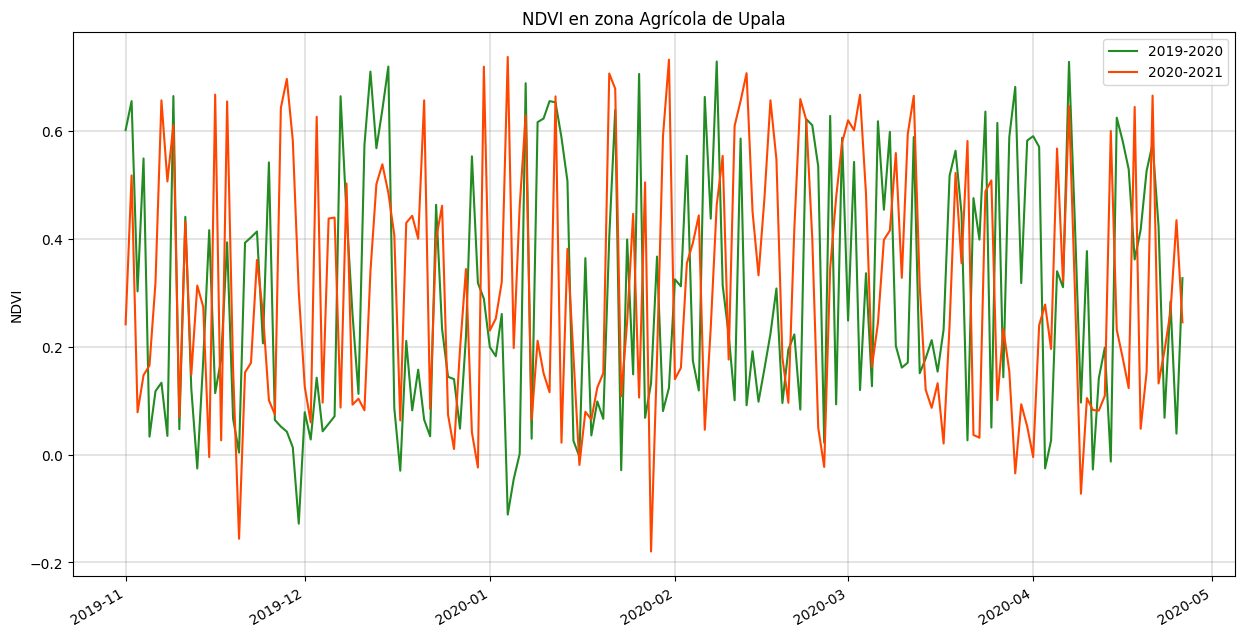

In [ ]:
serie_1 = [nov_2019, dic_2019,ene_2020,feb_2020,mar_2020,abr_2020]
serie_1 = np.asarray(serie_1)
serie_1 = np.concatenate(serie_1)
len(serie_1) 

serie_2 = [nov_2020, dic_2020,ene_2021,feb_2021,mar_2021,abr_2021]
serie_2 = np.asarray(serie_2)
serie_2 = np.concatenate(serie_2)
len(serie_2)

s = pd.Series(pd.date_range('2019-11-1-', periods=178, freq='d'))
s

fig = plt.figure(figsize=(15,8),dpi=100)
plt.plot(s,serie_1 ,label= '2019-2020', color = 'forestgreen')
plt.plot(s,serie_2 ,label= '2020-2021', color = 'orangered')
plt.title("NDVI en zona Agrícola de Upala")
plt.ylabel('NDVI')
plt.legend(loc = "best")
plt.grid(True, linewidth=0.3, color = 'gray')
fig.autofmt_xdate()